# Word-level embedding and query search engine

# Training initial embeddings 

In [39]:
# !pip install unidecode
# !pip install faiss-cpu

import re
from typing import Union, List, Tuple, Callable

import nltk
import faiss
import numpy as np
from unidecode import unidecode
from gensim.models import FastText
from gensim.models.word2vec import PathLineSentences

In [ ]:
# nltk.download('punkt_tab')

nltk.data.path.append('./nltk_data')
nltk.download('punkt_tab', download_dir='./nltk_data')

# Set seed for reproducibility
# Note that in order to do the computations trully determenistic
# it is required to run the code using a sigle thread
seed = 42

[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


Load war and peace text file from Gutenberg project repository.

In [ ]:
# !wget "https://www.gutenberg.org/files/2600/2600-0.txt" -O war_and_peace_raw.txt


# Для VS Code
# Invoke-WebRequest -Uri "https://www.gutenberg.org/files/2600/2600-0.txt" -OutFile "war_and_peace_raw.txt"

In [103]:
wap_raw_file_path = 'war_and_peace_raw.txt'
wap_cleaned_file_path = 'war_and_peace_cleaned.txt'

Note that the text contains information redundant for the task, so we need to preprocess the file first.

In [8]:
# !head war_and_peace_raw.txt


# Для VS Code
# Get-Content war_and_peace_raw.txt -Head 10

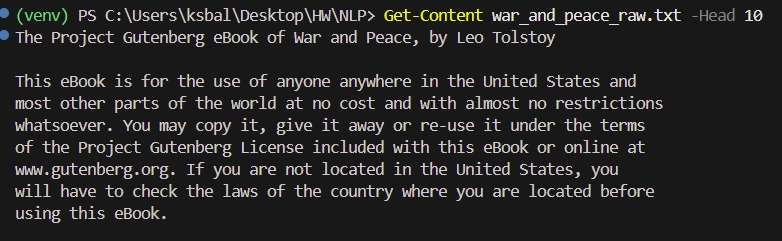

In [121]:
# Load the text from the file
with open(wap_raw_file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [122]:
# Remove the header and footer
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE ***"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK WAR AND PEACE ***"
text = text.split(start_marker, 1)[-1]  # Remove everything before the start marker
text = text.split(end_marker, 1)[0]     # Remove everything after the end marker

# Split the text into lines and filter out unwanted ones
lines = text.split("\n")
filtered_lines = []
for line in lines:
    line = line.strip()
    # Remove lines that are empty or contain chapter headers or non-content information
    if not line or line.startswith("CHAPTER") or line.isupper():
        continue
    filtered_lines.append(line)

# Join the lines back into a single string
cleaned_text = "\n".join(filtered_lines[2:])

In [123]:
# Посмотрим что осталось в первых 100 символах
print(cleaned_text[:100])

“Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if


In [124]:
# Normalize to ASCII
cleaned_text_ascii = unidecode(cleaned_text)

In [125]:
print(cleaned_text_ascii[:100])

"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if


In [126]:
# Split into sentences
sentences = nltk.sent_tokenize(cleaned_text_ascii)

sentences[:10]

['"Well, Prince, so Genoa and Lucca are now just family estates of the\nBuonapartes.',
 "But I warn you, if you don't tell me that this means war,\nif you still try to defend the infamies and horrors perpetrated by that\nAntichrist--I really believe he is Antichrist--I will have nothing\nmore to do with you and you are no longer my friend, no longer my\n'faithful slave,' as you call yourself!",
 'But how do you do?',
 'I see I\nhave frightened you--sit down and tell me all the news."',
 'It was in July, 1805, and the speaker was the well-known Anna Pavlovna\nScherer, maid of honor and favorite of the Empress Marya Fedorovna.',
 'With these words she greeted Prince Vasili Kuragin, a man of high\nrank and importance, who was the first to arrive at her reception.',
 'Anna\nPavlovna had had a cough for some days.',
 'She was, as she said, suffering\nfrom la grippe; grippe being then a new word in St. Petersburg, used\nonly by the elite.',
 'All her invitations without exception, written in

In [176]:
def clean_wap_sentence(sentence: str) -> str:
    """
    Cleans a sentence by performing the following operations:
    1. Replaces newline characters (`\n`) with a space.
    2. Replaces double hyphens (`--`) with a space.
    3. Removes all punctuation except for apostrophes.
    4. Converts the sentence to lowercase.

    Args:
        sentence (str): The input sentence to be cleaned.

    Returns:
        str: The cleaned sentence.
    """

    sentence = re.sub(r"\n|--", " ", sentence)
    sentence = re.sub(r"[^a-zA-Z\s']", " ", sentence)
    sentence = re.sub(r"\s+", " ", sentence).strip().lower()

    return sentence


In [177]:
clean_wap_sentence(sentences[0])

'well prince so genoa and lucca are now just family estates of the buonapartes'

In [178]:
# Preprocess each sentence
processed_sentences = []

for sentence in sentences:
    processed_sentences.append(clean_wap_sentence(sentence))

# Join processed sentences with newlines to match expected gensim format
final_text = "\n".join(processed_sentences)

with open(wap_cleaned_file_path, 'w') as outfile:
    outfile.write(final_text)

# Keep sentence count for gensim model parameter setting
wap_sentences_count = len(processed_sentences)

In [179]:
wap_sentences_count

32043

In [180]:
# Take a look at what we obtained so far
# !sed -n 1,4p war_and_peace_cleaned.txt

!powershell "Get-Content war_and_peace_cleaned.txt -Head 10"

well prince so genoa and lucca are now just family estates of the buonapartes
but i warn you if you don't tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichrist i really believe he is antichrist i will have nothing more to do with you and you are no longer my friend no longer my 'faithful slave ' as you call yourself
but how do you do
i see i have frightened you sit down and tell me all the news
it was in july and the speaker was the well known anna pavlovna scherer maid of honor and favorite of the empress marya fedorovna
with these words she greeted prince vasili kuragin a man of high rank and importance who was the first to arrive at her reception
anna pavlovna had had a cough for some days
she was as she said suffering from la grippe grippe being then a new word in st petersburg used only by the elite
all her invitations without exception written in french and delivered by a scarlet liveried footman that morning ran as follows

In [181]:
# Use PathLineSentence to stream data from the file
wap_sentences = PathLineSentences(wap_cleaned_file_path)

# Train the FastText model using Gensim
model = FastText(sg=1, vector_size=130, alpha=3e-2, window=5, seed=42)
model.build_vocab(corpus_iterable=wap_sentences)
model.train(corpus_iterable=wap_sentences, total_examples=wap_sentences_count, epochs=7)

model.save("wap_fasttext_model.bin")

You can play around with the model you trained below.

In [182]:
print(*model.wv.most_similar('peace', topn=10), sep='\n')

('disgrace', 0.7932349443435669)
('renounce', 0.7868367433547974)
('secrecy', 0.784319281578064)
('choice', 0.7753890156745911)
('fulfill', 0.7717003226280212)
('rejoice', 0.7705163359642029)
('religion', 0.7661436200141907)
('peaceful', 0.764767587184906)
('source', 0.7639528512954712)
('profit', 0.760312020778656)


In [183]:
print(*model.wv.most_similar('friends', topn=10), sep='\n')

('friendship', 0.9155310988426208)
('friend', 0.8754866719245911)
('friendly', 0.8111559748649597)
('children', 0.7994208931922913)
('husbands', 0.7972123026847839)
("friend's", 0.7893474102020264)
('sisters', 0.784108579158783)
('misfortunes', 0.766238808631897)
('nowadays', 0.7607471346855164)
('daughters', 0.759757399559021)


В целом, получилось неплохо. Оставим такие параметры

Fasttext allows us to reconstruct out-of-vocabulary words using word n-grams...

In [184]:
'computation' in model.wv.key_to_index

False

...even though they may be too far from the learned context.

In [185]:
print(*model.wv.most_similar('computation', topn=10), sep='\n')

('consultation', 0.9466596841812134)
('deputation', 0.945743978023529)
('participation', 0.9369222521781921)
('determination', 0.9347773790359497)
('combination', 0.9340638518333435)
('gravitation', 0.9335934519767761)
('manifestation', 0.9304137825965881)
('subordination', 0.9302160143852234)
('temptation', 0.9281273484230042)
('vocation', 0.9268414974212646)


In [187]:
# Degugging area
model_vocabulary = set(model.wv.key_to_index.keys())
most_similar_to_peace = list(zip(*model.wv.most_similar('peace', topn=50)))[0]

assert model.vector_size >= 64 and model.vector_size <= 300, 'Please check your embedding size.'
assert model.sg == 1, 'Please use skip-gram method for consistency. Also, despite being faster, CBOW usually generates inferior word embeddings for rare words.'
assert model.alpha == 3e-2, 'It is expected that you overwrite the default alpha for this task.'
assert len(model_vocabulary) > 5500 and len(model_vocabulary) < 7500, 'There is something wrong with your tokenization. Check the pipeline and use a default *ngram=1*'
assert 'religion' in most_similar_to_peace, 'Embeddings look odd. Make sure to follow instructions!'

print('Congrats!')

Congrats!


# Finetune using quora dataset 

In [ ]:
# download the data
# !wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora_raw.txt
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

# Invoke-WebRequest -Uri "https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1" -OutFile "quora_raw.txt"

In [190]:
# Glimpse at the quora dataset
# !sed -n 1,5p quora_raw.txt


# Get-Content quora_raw.txt -Head 5

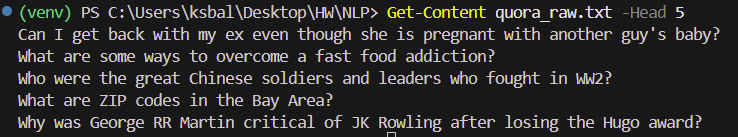

As before, we need to standardize the data for training.

Luckily for us, each line already consists of a complete sentence (even better, in ASCII!).

In [318]:
# Define a function to preprocess a single line
def preprocess_line(line: str) -> str:
    """
    Preprocesses a single line of text by:
    1. Removing all punctuation except apostrophes.
    2. Converting the text to lowercase.

    Args:
        line (str): The input line of text to preprocess.

    Returns:
        str: The preprocessed line of text.
    """

    line = re.sub(r"[^a-zA-Z\s']", "", line).lower().strip()

    return line

# Preprocess the text file line by line
def preprocess_file(input_file_path: str, output_file_path: str) -> int:
    """
    Reads a text file line by line, preprocesses each line,
    and writes the preprocessed lines to a new file.

    Args:
        input_file_path (str): Path to the input text file.
        output_file_path (str): Path to the output text file where preprocessed lines will be saved.

    Returns:
        int: The total number of lines processed in the input file.
    """
    processed_sentences = []

    with open(input_file_path, 'r', encoding='utf-8') as file:
      text = file.read()

    lines_processed = 0

    for sentence in text.split('\n'):
      if sentence != '':
        processed_sentences.append(preprocess_line(sentence))
        lines_processed+=1


    final_text = "\n".join(processed_sentences)

    with open(output_file_path, 'w') as outfile:
        outfile.write(final_text)

    return lines_processed


# Paths to the input and output files
quora_raw_file_path = 'quora_raw.txt'
quora_processed_file_path = 'quora_processed.txt'

# Preprocess the file and count the number of lines processed
quora_sentences_count = preprocess_file(quora_raw_file_path, quora_processed_file_path)

print(f'Lines processed: {quora_sentences_count}')

Lines processed: 537272


In [319]:
# As before, use gensim's tools to iterate over the lines
quora_sentences = PathLineSentences(quora_processed_file_path)

# Load the model in order to finetune it
finetuned_model = FastText.load("wap_fasttext_model.bin")

# Update existing vocabulary with the new sentences
finetuned_model.build_vocab(corpus_iterable=quora_sentences, update=True)

# Continue training the model on the new data
# Remember to correctly pass the parameters
finetuned_model.train(corpus_iterable=quora_sentences, total_examples=quora_sentences_count, epochs=5, start_alpha=1e-4)

finetuned_model.save("wap_quora_fasttext_model.bin")

In [320]:
finetuned_model_vocabulary = set(finetuned_model.wv.key_to_index.keys())
new_words = finetuned_model_vocabulary - model_vocabulary

print("Number of new words added:", len(new_words))
print("New words:", list(new_words)[10:20])

Number of new words added: 22745
New words: ['callers', 'poultry', 'africanamerican', 'pedophile', 'commonly', 'ws', 'rajput', 'invent', 'sde', 'guinness']


In [321]:
def print_comparison(
    model1: Union[FastText, None],
    model2: Union[FastText, None],
    word: str = 'peace',
    top_n: int = 10
) -> None:
    """
    A utility function that compares the top-N most similar words for a given query word across two FastText models.
    Prints the comparison in a tabular format to visually assess changes after finetuning.

    Args:
        model1 (FastText | None): The first FastText model (original or pre-finetuning).
        model2 (FastText | None): The second FastText model (post-finetuning).
        word (str, optional): The word for which similar words are retrieved.
        top_n (int, optional): The number of top similar words to compare.

    Returns:
        None: Prints results directly to the console.
    """
    q0 = model1.wv.most_similar(word, topn=top_n)
    q1 = model2.wv.most_similar(word, topn=top_n)

    # Print the header
    print(f'Query: {word}\n')
    print(f"{'pos':<5} {'model_1':<15} {'score_1':<10} {'model_2':<15} {'score_2':<10}")
    print("-" * (5 + 15 + 10 + 15 + 10))

    # Print each entry up to top_n
    for pos, (word0, score0), (word1, score1) in zip(range(top_n), q0, q1):
        # Format the scores to 4 decimal places
        print(f"{pos:<5} {word0:<15} {score0:.4f}     {word1:<15} {score1:.4f}")


In [322]:
# Call the function to display results
print_comparison(model, finetuned_model, word='war', top_n=10)

Query: war

pos   model_1         score_1    model_2         score_2   
-------------------------------------------------------
0     campaign        0.7648     warg            0.9204
1     warfare         0.7490     warby           0.8962
2     campaigns       0.7453     warfare         0.8709
3     probability     0.7418     zawar           0.8707
4     considerable    0.7363     warhol          0.8698
5     vital           0.7359     inventory       0.8695
6     nobility        0.7333     actuarial       0.8678
7     discussion      0.7314     revolution      0.8671
8     wars            0.7251     occipital       0.8668
9     universal       0.7220     vital           0.8651


In [323]:
print_comparison(model, finetuned_model, word='friends', top_n=10)

Query: friends

pos   model_1         score_1    model_2         score_2   
-------------------------------------------------------
0     friendship      0.9155     boyfriends      0.9870
1     friend          0.8755     exgirlfriends   0.9822
2     friendly        0.8112     friends'        0.9802
3     children        0.7994     girlfriends     0.9793
4     husbands        0.7972     friendships     0.9605
5     friend's        0.7893     friendsfamily   0.9596
6     sisters         0.7841     friendzone      0.9509
7     misfortunes     0.7662     friendship      0.9504
8     nowadays        0.7607     friendster      0.9494
9     daughters       0.7598     friend'         0.9449


In [324]:
# The usual assert wall for debugging and testing
assert finetuned_model.alpha <= model.min_alpha, 'setting a learning rate too high will result in model forgetting previous information, especially when finetuning on a larger dataset!'
assert len(new_words) > 20_000 and len(new_words) < 30_000, 'There is likely something wrong with your preprocessing pipeline. There must be more new words after finetuning!'
assert 'religion' in list(zip(*finetuned_model.wv.most_similar('peace', topn=50)))[0], 'Embeddings changed dramatically! Consider setting lower start_apha and fewer epochs.'
assert 'evolution' in list(zip(*finetuned_model.wv.most_similar('war', topn=50)))[0], 'Embeddings didn\'t change as was expected! Consider setting higher start_apha and more epochs, check *total_examples* param.'

print('Gratz!')

Gratz!


In practice, you may want to experiment with different fine-tuning strategies e.g. varying the alpha parameter, training for more epochs, or even trying to "freeze" some embeddings while updating only certain parts of the vocabulary.

# Implement a way to search similar quora questions given a new query 

## Straightforward numpy array-based search

Next, if we are to do a semantic search engine, it is required to be able to match a new sentence to a single vector. The easiest way to do so is to average individual word-level embeddings.

Alternatively, you may try out pooling (min, max, mean, softmax) strategies and [TF-IDF](https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/) . TF-IDF approach requires to precalculate IDF scores across existing corpus and multiply by a TF for a given word in a given sentence.

Also, it is expected that you will use cosine similarity as a vector distance metric later, so it might be a good idea to normalize all the vectors before putting them into a database since it will effectively turn a cosine similarity calculation into taking a dot product, which will speed the things up:
$$
cos(\phi) = \frac{<u, v>}{|u||v|}.
$$

In [325]:
def normalize_vector(embedding: np.ndarray) -> np.ndarray:
    """
    Normalizes a given vector to have unit length.

    Args:
        embedding (np.ndarray): A NumPy array representing the vector to normalize.

    Returns:
        np.ndarray: A normalized vector with unit length.
    """
    norm = np.linalg.norm(embedding)
    
    return embedding / norm


def get_text_embedding(text: str, model: FastText) -> np.ndarray:
    """
    Computes the embedding for a given text using a pre-trained FastText model.
    The embedding is the mean of word embeddings for words in the text, normalized to unit length.

    Args:
        text (str): The input text to embed.
        model (FastText): The FastText model to use for generating embeddings.

    Returns:
        np.ndarray: The normalized embedding for the input text.
                    If no valid words are found in the text, returns a zero vector.
    """

    vector_dim = model.vector_size
    words = preprocess_line(text).split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    
    if not word_vectors:
        return np.zeros(vector_dim, dtype=np.float32)
    
    mean_vector = np.mean(word_vectors, axis=0)
    normalized_embedding = normalize_vector(mean_vector)
    
    return normalized_embedding

In [326]:
# Debugging and testing area
question = "Love peace"
text_embedding = get_text_embedding(question, finetuned_model)
dummy_word_embedding = (finetuned_model.wv['love'] + finetuned_model.wv['peace']) / 2

assert text_embedding.shape[0] == finetuned_model.wv.vector_size, "Check axis along which values are aggregated"
assert all(normalize_vector(dummy_word_embedding) == text_embedding), "You need to return a normalized mean embedding for now, nothing fancy!"

print('Good job!')

Good job!


In [327]:
def create_embeddings_storage(quora_file: str, model: FastText) -> np.ndarray:
    """
    Creates a NumPy array of normalized embeddings for all questions in a dataset.

    Each line in the input file represents a question, which is preprocessed using
    'preprocess_line' function and embedded using 'get_text_embedding' function.

    Args:
        quora_file (str): Path to the file containing the preprocessed questions, one per line.
        model (FastText): The FastText model used to generate embeddings.

    Returns:
        np.ndarray: A 2D NumPy array where each row corresponds to the normalized embedding
                    of a question in the dataset. Shape: (num_questions, embedding_dim).
    """
    embeddings_list: List[np.ndarray] = []

    with open(quora_file, 'r', encoding='utf-8') as file:
        lines = file.readlines() 

    for line in lines:
        line = line.rstrip('\r\n')
        embedding = get_text_embedding(line, model)
        embeddings_list.append(embedding)

    # Convert the list of embeddings to a NumPy array
    return np.array(embeddings_list)

In [328]:
# Create a storage array for normalized embeddings
embeddings_storage_np = create_embeddings_storage("quora_processed.txt", finetuned_model)

In [332]:
with open(quora_processed_file_path, 'r') as f:
    for line in f:
        test_embedding = get_text_embedding(line, finetuned_model)
        break

assert embeddings_storage_np.shape == (quora_sentences_count, finetuned_model.vector_size), "The vector storage must be of size (num_quora_sentences, embedding_dim)"
assert embeddings_storage_np[0].mean() == test_embedding.mean(), 'Embedding of the first quora question does not correspond to the first enty in the storage!'
print('Looking good so far!')

Looking good so far!


In [333]:
def find_closest_match_np(query: str, model, embeddings_storage: np.ndarray, k: int = 1) -> Tuple[List[int], List[float]]:
    """
    Finds the closest match(es) to a new question in the database using cosine similarity.

    This function preprocesses the input question, calculates its embedding, and then computes
    cosine similarities between the new question's embedding and a pre-existing database of embeddings.
    It returns the indices of the top-k most similar questions along with their similarity scores.

    Parameters:
        query (str): The input question to be compared.
        model: The trained FastText model used to generate word embeddings.
        embeddings_storage (np.ndarray): A numpy array containing the precomputed and normalized embeddings of all questions in the database.
        k (int, optional): The number of closest matches to return. Defaults to 1.

    Returns:
        Tuple[List[int], List[float]]:
            - List[int]: A list of indices of the top-k most similar questions in the database.
            - List[float]: A list of similarity scores corresponding to these top-k matches.
    """

    # Preprocess the query and embed the question
    query_embedding = get_text_embedding(query, model)

    # Compute cosine similarity
    # Dot product if the vectors are normalized embeddings
    # You might want to look up np.dot
    similarities = np.dot(embeddings_storage, query_embedding)

    # Get the indices of the top-k most similar questions
    # You might want to look up np.argsort
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    top_k_similarities = similarities[top_k_indices].tolist()
    top_k_indices = top_k_indices.tolist()

    return top_k_indices, top_k_similarities


In [334]:
# Store original questions for visual testing
quora_questions_list = []
with open(quora_raw_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        quora_questions_list.append(line.strip())

print(f"Total questions processed: {len(quora_questions_list)}")

Total questions processed: 537272


In [335]:
def fetch_and_display_closest_match(query_function: Callable[..., Tuple[List[int], List[float]]], **kwargs) -> Tuple[List[int], List[float]]:
    """
    A utility function to fetch and display the closest matching questions
    from the Quora dataset for a given query.

    This function takes a query, uses the provided query function to retrieve
    the top-k most similar questions, and prints them along with their similarity scores.

    Args:
        query_function (Callable): A function that takes query-related parameters and returns
                                    the indices of the top-k most similar questions and their similarity scores.
                                    It should return a tuple (List[int], List[float]).
        **kwargs: Additional arguments to be passed to the query_function, including the query text.

    Returns:
        Tuple[List[int], List[float]]: A tuple containing:
            - A list of indices corresponding to the top-k most similar questions in the dataset.
            - A list of similarity scores for each of these questions.
    """

    # Retrieve the top-k indices and their similarity scores from the query function
    top_k_indices, top_k_similarities = query_function(**kwargs)

    # Fetch the actual questions based on the retrieved indices
    top_k_questions = [quora_questions_list[i] for i in top_k_indices]

    # Print the query and the top-k results with their similarity scores
    print(f"Query: {kwargs['query']}")
    print("\nTop Matches:")
    for i, (question, similarity) in enumerate(zip(top_k_questions, top_k_similarities), 1):
        print(f"{i}. {question} (Similarity: {similarity:.4f})")

    return top_k_indices, top_k_similarities


In [336]:
# testing area
new_question = "How can I find inner peace?"

top_k_indices, top_k_similarities = fetch_and_display_closest_match(query_function=find_closest_match_np,
                                                                    query=new_question, model=finetuned_model,
                                                                    embeddings_storage=embeddings_storage_np,
                                                                    k=10)

assert 446084 in top_k_indices, 'Your embeddings look odd. = ('

Query: How can I find inner peace?

Top Matches:
1. How can I create inner peace? (Similarity: 0.9905)
2. How can I find a career mentor? (Similarity: 0.9900)
3. How can I find a successful mentor? (Similarity: 0.9895)
4. How can I find a programmer mentor? (Similarity: 0.9888)
5. How can I find passion? (Similarity: 0.9878)
6. How can I find a job? (Similarity: 0.9878)
7. How can I find a perfect co-founder? (Similarity: 0.9878)
8. How can I find a startup mentor? (Similarity: 0.9877)
9. How can I find the job I can enjoy? (Similarity: 0.9876)
10. How can I find a trustworthy distributor？? (Similarity: 0.9872)


In [337]:
new_question = "What is the future of artificial intelligence?"

_, _ = fetch_and_display_closest_match(query_function=find_closest_match_np,
                                       query=new_question, model=finetuned_model,
                                       embeddings_storage=embeddings_storage_np,
                                       k=10)


Query: What is the future of artificial intelligence?

Top Matches:
1. What is the future of artificial intelligence? (Similarity: 1.0000)
2. What is the future of internet piracy? (Similarity: 0.9960)
3. What is the scope of Artificial Intelligence? (Similarity: 0.9957)
4. What is the future of Social Media? (Similarity: 0.9957)
5. What is the future of Pharmaceutical industry? (Similarity: 0.9957)
6. What is the future of Chinese economy? (Similarity: 0.9955)
7. What is the future of Indonesia's economy? (Similarity: 0.9950)
8. What is the future of electrical grid? (Similarity: 0.9949)
9. What is the future of Behavioural Economics? (Similarity: 0.9949)
10. What is the future of American journalism? (Similarity: 0.9946)


In [338]:
import time

iterations = 100

start_time = time.time()

for _ in range(iterations):
    _, _ = find_closest_match_np('hello there', finetuned_model, embeddings_storage_np, k=10)

time_elapsed = time.time() - start_time
average_time = time_elapsed / iterations

print(f'Time elapsed: {time_elapsed:.4f} seconds.')
print(f'Average time: {average_time:.4f} seconds.')

Time elapsed: 4.5022 seconds.
Average time: 0.0450 seconds.


# Vector database search

In [339]:
def build_faiss_hnsw_index(dimension: int, ef_construction: int = 200, M: int = 32) -> faiss.IndexHNSWFlat:
    """
    Builds a FAISS HNSW index for cosine similarity.

    This function initializes a HNSW (Hierarchical Navigable Small World) index for efficient approximate nearest neighbor search
    based on cosine similarity, using the FastText model's normalized embeddings.

    Parameters:
        dimension (int): Dimensionality of the embeddings (size of each vector).
        ef_construction (int, optional): Trade-off parameter between index construction speed and accuracy. Default is 200.
        M (int, optional): Number of neighbors in the graph, controlling the memory and accuracy tradeoff. Default is 32.

    Returns:
        index (faiss.IndexHNSWFlat): Initialized FAISS HNSW index.
    """
    index = faiss.IndexHNSWFlat(dimension, M)  # HNSW index
    index.hnsw.efConstruction = ef_construction  # Construction accuracy
    index.metric_type = faiss.METRIC_INNER_PRODUCT  # Cosine similarity via normalized vectors
    return index


def populate_faiss_index(index: faiss.Index, model, dataset_path: str, batch_size: int = 10000):
    """
    Populates the FAISS HNSW index with normalized embeddings from the dataset.

    This function reads the dataset line by line, preprocesses each question, computes its embedding,
    and adds the embeddings to the FAISS index in batches.

    Parameters:
        index (faiss.Index): FAISS index to populate.
        model: Trained FastText model used to generate embeddings.
        dataset_path (str): Path to the dataset file (one question per line).
        batch_size (int, optional): Number of questions to process at a time. Default is 10000.
    """
    with open(dataset_path, "r") as f:
        buffer = []
        for line in f:
            # Preprocess the line and get its embedding
            question = preprocess_line(line.strip())
            embedding = get_text_embedding(question, model)
            buffer.append(embedding)

            # Add embeddings to the index in batches
            if len(buffer) >= batch_size:
                index.add(np.array(buffer, dtype=np.float32))
                buffer = []  # Clear the buffer after adding

        # Add remaining embeddings (if any) after loop finishes
        if buffer:
            index.add(np.array(buffer, dtype=np.float32))


def search_faiss_index(embeddings_storage: faiss.Index, query: str, model, k: int = 5) -> Tuple[List[int], List[float]]:
    """
    Searches the FAISS index for the closest matches to a query.

    This function computes the embedding for the input query, searches the FAISS index for the most similar questions,
    and returns the indices and distances (cosine similarity) of the top-k matches.

    Parameters:
        embeddings_storage (faiss.Index): FAISS index to search.
        query (str): The input query string to search for.
        model: Trained FastText model used to generate embeddings.
        k (int, optional): Number of closest matches to retrieve. Default is 5.

    Returns:
        Tuple[List[int], List[float]]:
            - List[int]: A list of indices of the top-k most similar questions.
            - List[float]: A list of distances (cosine similarity) of the top-k results.
    """
    # Preprocess and normalize the query embedding
    query_embedding = get_text_embedding(query, model)

    # Search the embeddings_storage (FAISS index)
    top_k_distances, top_k_indices = embeddings_storage.search(np.array([query_embedding], dtype=np.float32), k)

    # Match return format with that used in numpy storage search
    top_k_indices_list = top_k_indices[0].tolist()
    top_k_distances_list = top_k_distances[0].tolist()

    return top_k_indices_list, top_k_distances_list


In [340]:
# Define the dimensions of the embedding vectors
embedding_dimension = finetuned_model.vector_size  # Depends on the FastText model

# Build the HNSW index
hnsw_index = build_faiss_hnsw_index(embedding_dimension)

# Populate the index from the quora_processed.txt dataset
populate_faiss_index(hnsw_index, finetuned_model, "quora_processed.txt")


Note that we built a FAISS index around Euclidian distance, not cosine similarity, to be completely honest:

$$
cosine \space similarity = 1 - \frac{euclidian \space distance^2}{2}
$$

Note that the results obtained may not entirely repeat a numpy-based search since HNSW index is built upon approximate computations.

In [341]:
# Example query
query_text = "How can I find inner peace?"

top_k_indices, top_k_similarities = fetch_and_display_closest_match(query_function=search_faiss_index,
                                                                    query=query_text, model=finetuned_model,
                                                                    embeddings_storage=hnsw_index,
                                                                    k=10)

Query: How can I find inner peace?

Top Matches:
1. How can I find a career mentor? (Similarity: -0.0200)
2. How can I find a successful mentor? (Similarity: -0.0211)
3. How can I find a programmer mentor? (Similarity: -0.0224)
4. How can I find passion? (Similarity: -0.0244)
5. How can I find a job? (Similarity: -0.0244)
6. How can I find a perfect co-founder? (Similarity: -0.0245)
7. How can I find a startup mentor? (Similarity: -0.0246)
8. How can I find the job I can enjoy? (Similarity: -0.0248)
9. How can I find a trustworthy distributor？? (Similarity: -0.0257)
10. How can I find a job online? (Similarity: -0.0262)


In [342]:
import time

iterations = 100

start_time = time.time()

for _ in range(iterations):
    _, _ = search_faiss_index(hnsw_index, query_text, finetuned_model, k=10)

time_elapsed = time.time() - start_time
average_time = time_elapsed / iterations

print(f'Time elapsed: {time_elapsed:.4f} seconds.')
print(f'Average time: {average_time:.4f} seconds.')

Time elapsed: 0.0040 seconds.
Average time: 0.0000 seconds.
